In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from matplotlib import cm
#import plotly.plotly as py
import seaborn as sns
from sklearn import linear_model
from sklearn.datasets.samples_generator import make_blobs
from sklearn.cluster import KMeans, MeanShift
import statsmodels.tsa.stattools as tsa
import tensorflow as tf

%matplotlib inline

with pd.HDFStore("../train.h5", "r") as df:
    train = df.get("train")

train_a = train.dropna(axis=0)
train_f = train.fillna(train.mean())

ImportError: No module named 'tensorflow'

In [4]:
IDs = train['id'].unique()
X_train = train.drop(['y','id','timestamp'],axis=1)
NaNMat = np.zeros([IDs.shape[0], train.columns.shape[0]-3])
for i, j in enumerate(IDs):
    NaNMat[i,:]=X_train[train['id']==j].isnull().sum(axis=0)/(train['id']==j).sum()

In [5]:
NaN_bin = 1*(NaNMat==1)

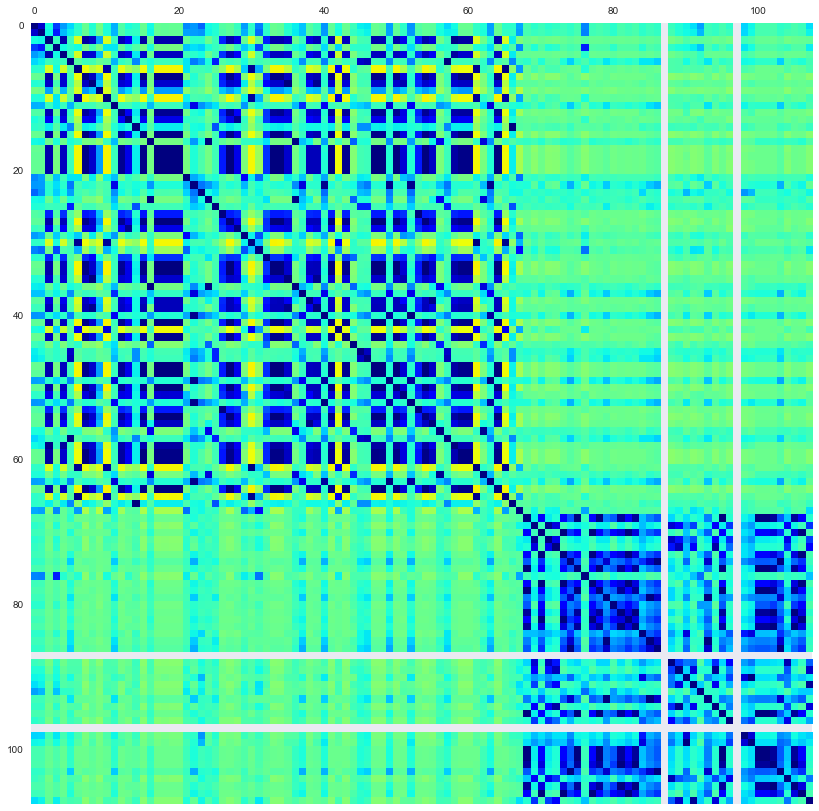

In [8]:
NaN_cov = np.corrcoef(NaN_bin.T)
fig, ax = plt.subplots(figsize=(18,14))
# plt.figure(figsize=(10,8))
ax.matshow(NaN_cov,vmin=-1, vmax=1,cmap='jet_r')
plt.grid()
# plt.colorbar()

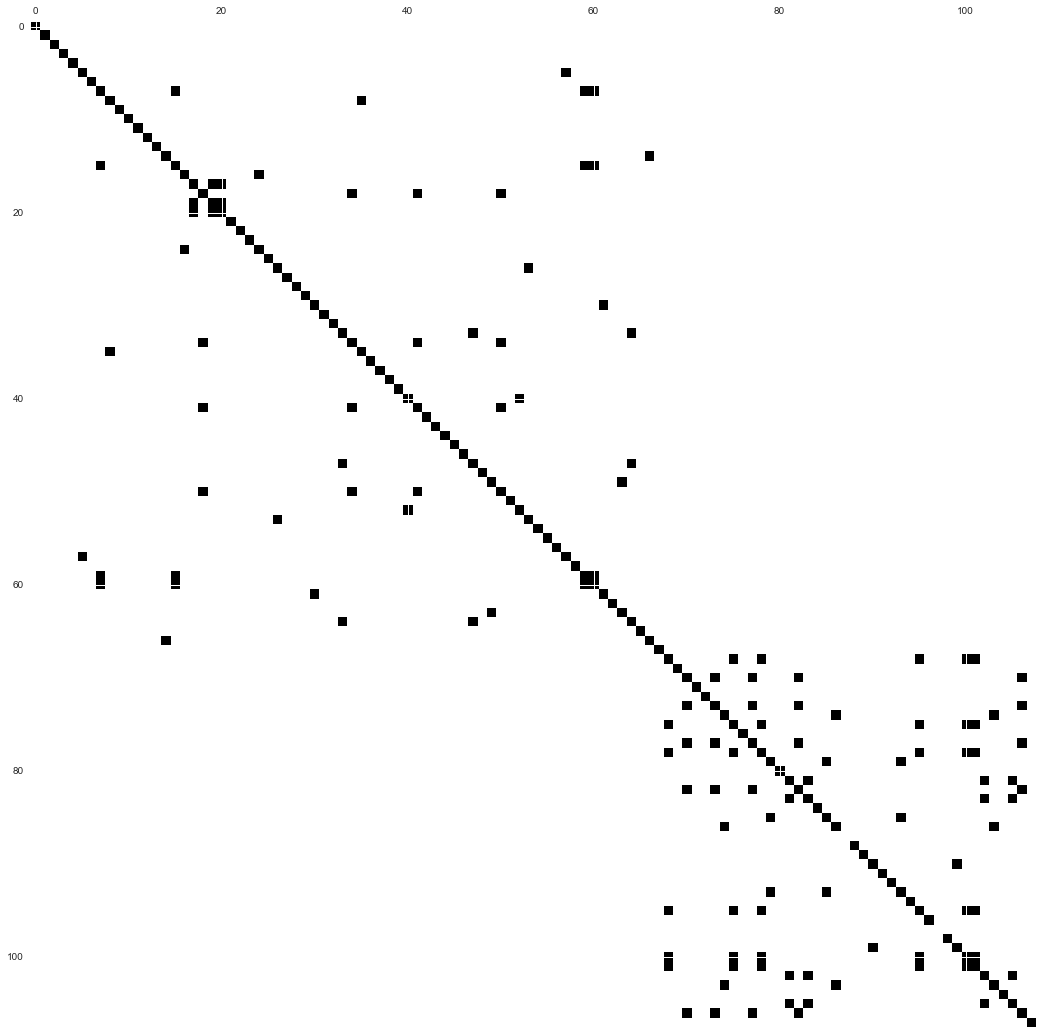

In [6]:
fig, ax = plt.subplots(figsize=(20,18))
ax.matshow(NaN_cov==1)

In [7]:
train.drop(['y','id','timestamp'],axis=1).head()

,derived_0,derived_1,derived_2,derived_3,derived_4,fundamental_0,fundamental_1,fundamental_2,fundamental_3,fundamental_5,...,technical_35,technical_36,technical_37,technical_38,technical_39,technical_40,technical_41,technical_42,technical_43,technical_44
0,0.370326,-0.006316,0.222831,-0.213030,0.729277,-0.335633,0.113292,1.621238,-0.179404,NaN,...,0.937880,0.775208,NaN,NaN,NaN,-0.414776,NaN,NaN,-2,NaN
1,0.014765,-0.038064,-0.017425,0.320652,-0.034134,0.004413,0.114285,-0.210185,0.216281,0.09675,...,0.232154,0.025590,NaN,NaN,NaN,-0.273607,NaN,NaN,-2,NaN
2,-0.010622,-0.050577,3.379575,-0.157525,-0.068550,-0.155937,1.219439,-0.764516,NaN,NaN,...,0.372688,0.151881,NaN,NaN,NaN,-0.175710,NaN,NaN,-2,NaN
3,NaN,NaN,NaN,NaN,NaN,0.178495,NaN,-0.007262,-0.097903,NaN,...,0.751021,1.035936,NaN,NaN,NaN,-0.211506,NaN,NaN,-2,NaN
4,0.176693,-0.025284,-0.057680,0.015100,0.180894,0.139445,-0.125687,-0.018707,0.196391,NaN,...,0.595206,0.630232,NaN,NaN,NaN,-0.001957,NaN,NaN,0,NaN


In [9]:
edges=[]
count = NaN_cov.sum
for i in range(NaN_cov.shape[0]):
    for j in range(NaN_cov.shape[0]-i):
        if(i+j!=i and NaN_cov[i,i+j]==1):
            edges.append([i,i+j, NaN_bin[:,i].sum()])

In [10]:
edges = np.array(edges)
edge_by_ID = np.zeros([NaN_bin.shape[0],len(edges)])

In [11]:
for i in range(edge_by_ID.shape[1]):
    edge_by_ID[:,i] = 1*((NaN_bin[:,edges[i][0]]==1) & (NaN_bin[:,edges[i][1]]==1))

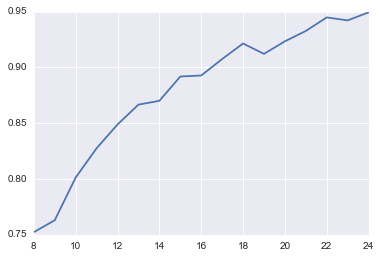

In [12]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
scores = []
for i in range(8,25):
    km = KMeans(n_clusters=i, random_state=0)
    km.fit(edge_by_ID)
    scores.append(silhouette_score(edge_by_ID, km.labels_))
plt.plot(range(8,25),scores)

In [13]:
km = KMeans(n_clusters=12, random_state=0)
km.fit(edge_by_ID)
colors = km.labels_
colors

array([ 1,  8,  8, ..., 10,  5,  5], dtype=int32)

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 1.,  1.,  1., ...,  1.,  1.,  1.],
       [ 1.,  1.,  1., ...,  1.,  1.,  1.]])

In [16]:
cols_to_use = ['fundamental_11', 'technical_19', 'technical_20', 'technical_30']
# cols_to_use = ['technical_20']
k = 0.75
cut = int(1812*k)
itrain = train['timestamp']<=cut
itest = ~itrain

In [64]:
km.labels_

array([ 1,  8,  8, ..., 10,  5,  5], dtype=int32)

In [66]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
# Outlier has not been removed
sc = StandardScaler()
X_train = pd.DataFrame(sc.fit_transform(train_f[cols_to_use][itrain]))
X_test = pd.DataFrame(sc.fit_transform(train_f[cols_to_use][itest]),index=train_f[itest].index)
y_train = train_f['y'][itrain]
y_test = train_f['y'][itest]
lr = LinearRegression()
# y_within = (train_f['y'][itrain]<y_high) & (train_f['y'][itrain]>y_low)
for count, i in enumerate(np.unique(km.labels_)):
    print count
    train_index = train.id[itrain].isin(IDs[km.labels_==i])
    test_index = train.id[itest].isin(IDs[km.labels_==i])
    lr.fit(X_train[train_index], y_train[train_index])
    y_test[test_index]=lr.predict(X_test[test_index])
#     score = lr.score(sc.fit_transform(train_f[cols_to_use][itest]), train_f['y'][itest])
print('linear regressor score: {:.6f}'.format(r2_score(y_test,train_f['y'][itest])))

0
1
2
3
4
5
6
7
8
9
10
11
linear regressor score: -2956.034799


In [42]:
test = pd.DataFrame([[1,2,3],[4,5,6],[7,8,9]])
test[[True,True,False]]

,0,1,2
0,1,2,3
1,4,5,6


In [29]:
test[0].isin([1,4,5])

0     True
1     True
2    False
Name: 0, dtype: bool

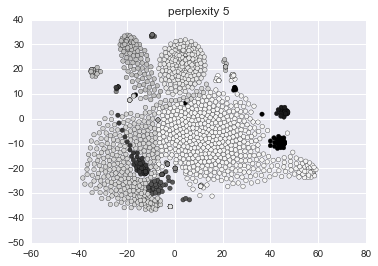

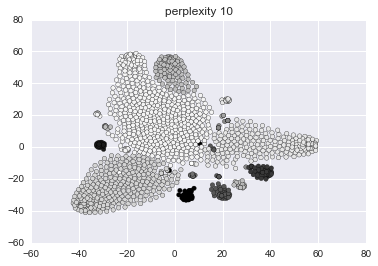

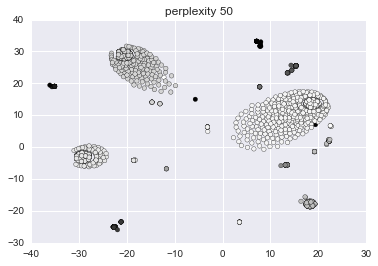

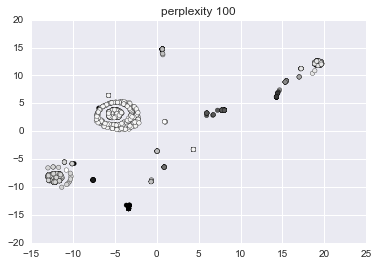

In [55]:
from sklearn.manifold import TSNE
n_iteration=5000
for i in [5,10,50,100]:
    ts = TSNE(n_components=2, perplexity=i,n_iter=n_iteration)
    X = ts.fit_transform(edge_by_ID)
    plt.scatter(X[:,0],X[:,1],c=colors*10)
    plt.title("perplexity {}".format(i))
    plt.show()

In [6]:
km = KMeans(n_clusters=12, random_state=0)
km.fit(edges)

NameError: name 'edges' is not defined

In [ ]:
km.labels_

In [109]:
count_rate = []
for i in [i for i in train.columns if i not in ['y', 'timestamp', 'id']]:
    temp = train[i].isnull().sum()
    count_rate.append(float(temp)/train.shape[0])

In [131]:
count_rate

array([ 0.04264723,  0.04736444,  0.23302622,  0.08737131,  0.2375897 ,
        0.01399791,  0.39694147,  0.21560059,  0.26560187,  0.56233618,
        0.4101257 ,  0.0153967 ,  0.21812929,  0.33059478,  0.06603922,
        0.21560059,  0.06480819,  0.20759126,  0.20814424,  0.20745039,
        0.20759126,  0.05682985,  0.00925497,  0.0319087 ,  0.06480819,
        0.03175964,  0.32645684,  0.20851775,  0.33707612,  0.07125154,
        0.38414829,  0.16442906,  0.39007959,  0.20698802,  0.20745624,
        0.26560187,  0.0652764 ,  0.00808707,  0.25419288,  0.24812188,
        0.00926082,  0.20800336,  0.46966897,  0.22070593,  0.16349614,
        0.01760333,  0.01339349,  0.20723645,  0.20798115,  0.00938883,
        0.20800336,  0.26089518,  0.00926082,  0.32636624,  0.20764563,
        0.26131897,  0.08997601,  0.01399791,  0.22458667,  0.21560059,
        0.21560059,  0.38414829,  0.08307731,  0.00938883,  0.20758425,
        0.39269247,  0.06603922,  0.21956024,  0.01120265,  0.07

In [134]:
miss_count_rate

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [176]:
count_rate = np.array(count_rate)
index = count_rate <= 0.3

In [177]:
comp_index = np.arange(108)[index]
comp_index

array([  0,   1,   2,   3,   4,   5,   7,   8,  11,  12,  14,  15,  16,
        17,  18,  19,  20,  21,  22,  23,  24,  25,  27,  29,  31,  33,
        34,  35,  36,  37,  38,  39,  40,  41,  43,  44,  45,  46,  47,
        48,  49,  50,  51,  52,  54,  55,  56,  57,  58,  59,  60,  62,
        63,  64,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,
        77,  78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,
        90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102,
       103, 104, 105, 106, 107])

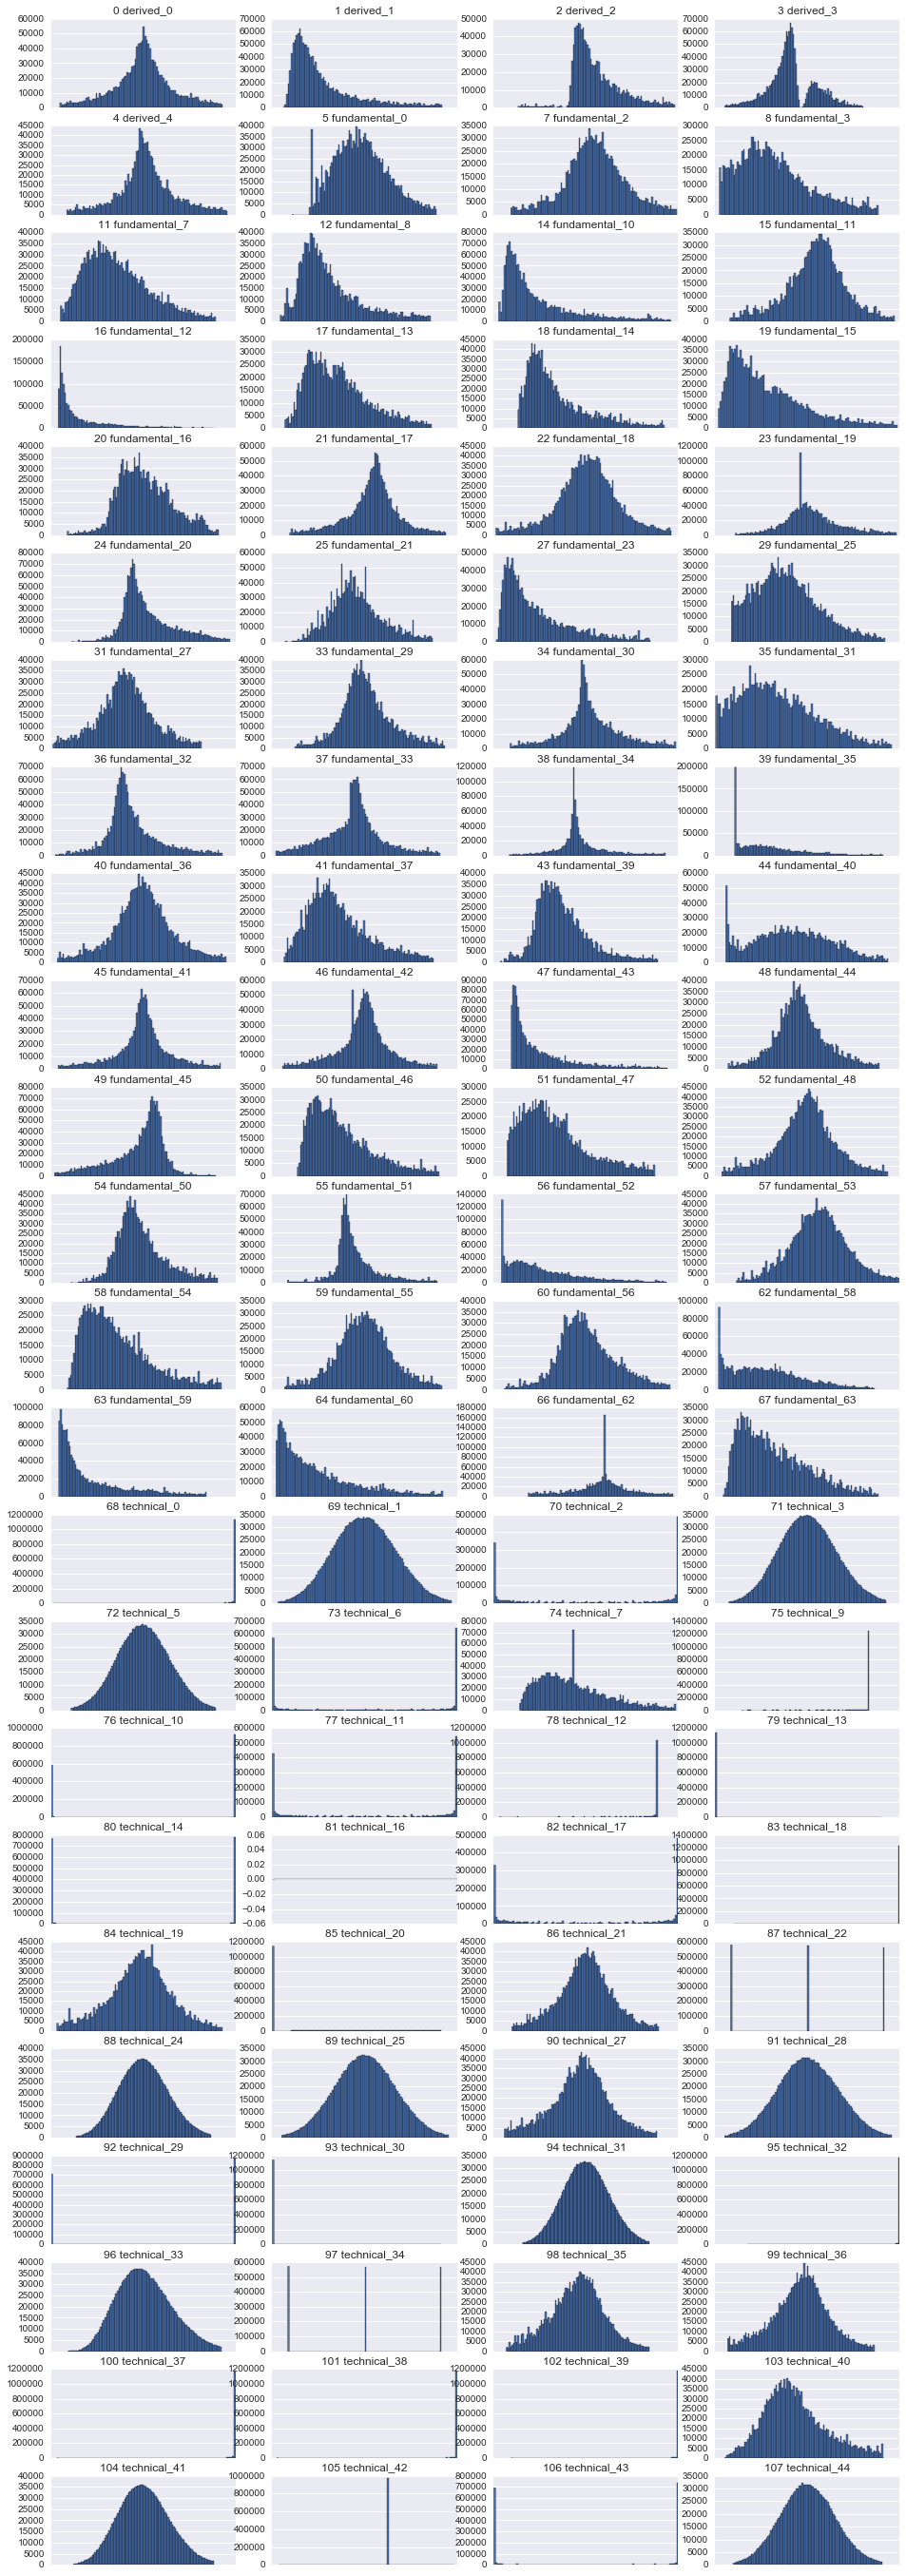

In [191]:
k = 0
plt.figure(figsize=(16,50))
col = train.drop(['y','id','timestamp'],axis=1).columns
for i in comp_index:
    k += 1
    col_ = train.drop(['y','id','timestamp'],axis=1).iloc[:,i]
    col_ = col_[col_.notnull()]
    high, low = col_.quantile(0.75), col_.quantile(0.25)
    iqr = (high-low)*1.5
    high, low = high+iqr, low-iqr
    col_ = col_[(col_<high) & (col_>low)]
    plt.subplot(25, 4, k)
    plt.hist(col_,bins=100)
    plt.xticks([])
    plt.title(str(i) + ' ' + col[i])
#     plt.tight_layout(pad=0)

In [47]:
bicate = ['technical_6','technical_10','technical_11','technical_14','technical_38','technical_43']
tricate = ['technical_22','technical_34']

In [54]:
index = np.array([True]*train.shape[0])
for i in bicate:
    index = index & train[i].notnull()
train_data = train[index][bicate+['y']]
train_data['technical_38'][train_data['technical_38']<=-0.5]=-1
train_data['technical_38'][train_data['technical_38']>-0.5]=0
train_data['technical_43'][train_data['technical_43']<=-1]=-2
train_data['technical_43'][train_data['technical_43']>-1]=0
train_data['technical_14'][train_data['technical_14']<=-1]=-2
train_data['technical_14'][train_data['technical_14']>-1]=0
train_data['technical_11'][train_data['technical_11']<=-1]=-2
train_data['technical_11'][train_data['technical_11']>-1]=0
train_data['technical_10'][train_data['technical_10']<=-1]=-2
train_data['technical_10'][train_data['technical_10']>-1]=0
train_data['technical_6'][train_data['technical_6']<=-1]=-2
train_data['technical_6'][train_data['technical_6']>-1]=0
print "Var:\n",train_data.groupby(bicate).var()
print "Mean:\n",train_data.groupby(bicate).mean()

Var:
                                                                                     y
technical_6 technical_10 technical_11 technical_14 technical_38 technical_43          
-2          -2           -2           -2           -1           -2            0.000742
                                                                 0                 NaN
                                                    0           -2            0.001020
                                                                 0            0.000509
                                       0           -1           -2            0.000266
                                                                 0            0.000108
                                                    0           -2            0.000405
                                                                 0            0.000349
                          0           -2           -1           -2            0.000702
                                      

In [55]:
index = np.array([True]*train.shape[0])
for i in tricate:
    index = index & train[i].notnull()
train_data = train[index][tricate+['y']]
print "Var:\n",train_data.groupby(tricate).var()
print "Mean:\n",train_data.groupby(tricate).mean()

Var:
                                  y
technical_22 technical_34          
-0.5         -0.5          0.000193
              0.0          0.000209
              0.5          0.000186
 0.0         -0.5          0.000396
              0.0          0.000387
              0.5          0.000354
 0.5         -0.5          0.001072
              0.0          0.000862
              0.5          0.000913
Mean:
                                  y
technical_22 technical_34          
-0.5         -0.5          0.000259
              0.0          0.000255
              0.5          0.000241
 0.0         -0.5          0.000221
              0.0          0.000226
              0.5          0.000212
 0.5         -0.5          0.000232
              0.0          0.000174
              0.5          0.000176


In [58]:
res = train_data.groupby(tricate).mean()

In [63]:
res.index

MultiIndex(levels=[[-0.5, 0.0, 0.5], [-0.5, 0.0, 0.5]],
           labels=[[0, 0, 0, 1, 1, 1, 2, 2, 2], [0, 1, 2, 0, 1, 2, 0, 1, 2]],
           names=[u'technical_22', u'technical_34'])

In [75]:
from itertools import product
for i in product(res.index.levels[0],res.index.levels[1]):
    print i

(-0.5, -0.5)
(-0.5, 0.0)
(-0.5, 0.5)
(0.0, -0.5)
(0.0, 0.0)
(0.0, 0.5)
(0.5, -0.5)
(0.5, 0.0)
(0.5, 0.5)


In [67]:
res

y
technical_22 technical_34          
-0.5         -0.5          0.000259
              0.0          0.000255
              0.5          0.000241
 0.0         -0.5          0.000221
              0.0          0.000226
              0.5          0.000212
 0.5         -0.5          0.000232
              0.0          0.000174
              0.5          0.000176